Import libraries and setup plot

In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output

`Solver` class inside `solver.py` represents a full simulation of a particular problem size.

In [2]:
from solver import Solver

To start a simulation, we need to create a solver for a particular size, e.g. (20, 20).

`plot_coverage` function plots its current coverage where:


- Black means not covered.
- Dark red means covered.

<IPython.core.display.Javascript object>


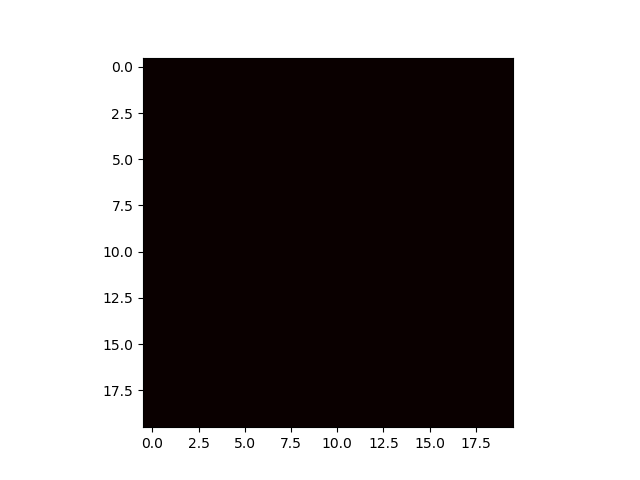

In [3]:
solver = Solver(width=20, height=20)
im = solver.plot_coverage()

Now let's create our first tower. `Tower` is a class provided in `tower.py` to represent a single tower. It holds the information about the coordinates and a weakref to the solver.

`Solver` class provides `create_tower` to create a tower with the following calling signature:

> def create_tower(self, x1, x2, y1, y2):

x1, x2, y1, y2 are integer coordinates within the defined space. Note that x1, y1 are **inclusive**, x2, y2 are **exclusive**.

In [4]:
first_tower = solver.create_tower(7, 20, 2, 7)

Now let's add the tower to the current solution. Since it's the first tower, it will not conflict with any existing towers. As a result we don't need to trim it.

`dump_towers` prints out the current towers inside the solution set. Let's also plot the coverage again.

Rank: 1	x1: 7	x2: 20	y1: 2	y2: 7


<IPython.core.display.Javascript object>


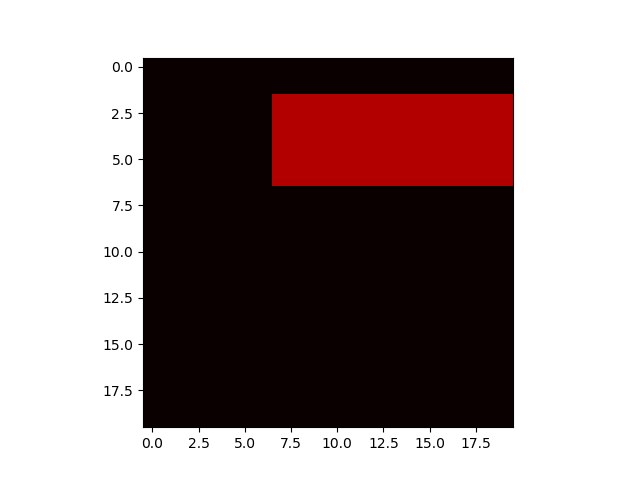

In [5]:
solver.add_tower(first_tower)
print solver.dump_towers()

plt.subplots()
im = solver.plot_coverage()

Let's add a few more towers. Coordinates are predefined so that none of them will overlap.

Rank: 1	x1: 7	x2: 20	y1: 2	y2: 7
Rank: 2	x1: 1	x2: 4	y1: 6	y2: 10
Rank: 3	x1: 6	x2: 10	y1: 7	y2: 14
Rank: 4	x1: 10	x2: 12	y1: 8	y2: 10
Rank: 5	x1: 15	x2: 19	y1: 8	y2: 12


<IPython.core.display.Javascript object>


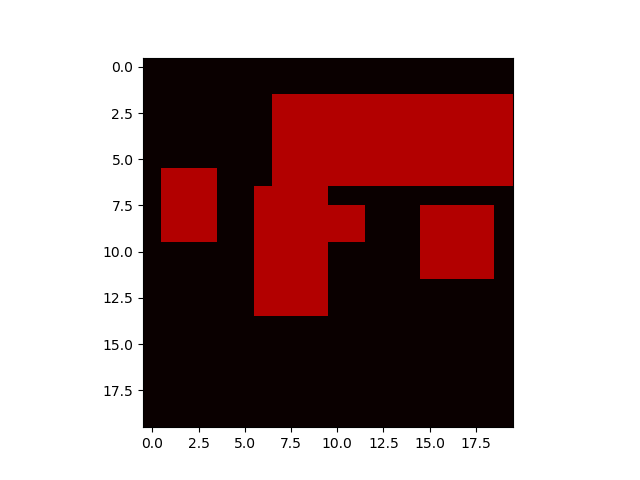

In [6]:
solver.add_tower(solver.create_tower( 1,  4,  6, 10))
solver.add_tower(solver.create_tower( 6, 10,  7, 14))
solver.add_tower(solver.create_tower(10, 12,  8, 10))
solver.add_tower(solver.create_tower(15, 19,  8, 12))

print solver.dump_towers()
plt.subplots()
im = solver.plot_coverage()

Now let's create another tower, which conflicts with all existing towers

<IPython.core.display.Javascript object>


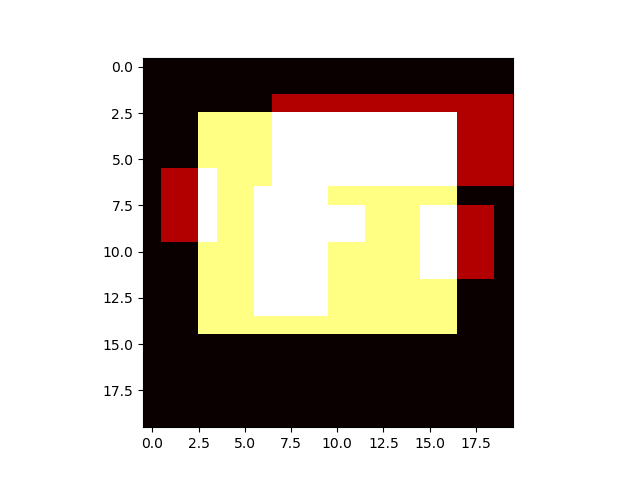

In [7]:
conflict_tower = solver.create_tower( 3, 17,  3, 15)

plt.subplots()
im = solver.plot_coverage_overlay(conflict_tower)

We can't add this tower to the solution. We have to trim it before adding to the solution. `Tower` class has a function `trim` which trims itself based on the current state of the solver it is related to.

Let's see the result of the `trim` and dig into the function after that (White area is the trimmed version):

<IPython.core.display.Javascript object>


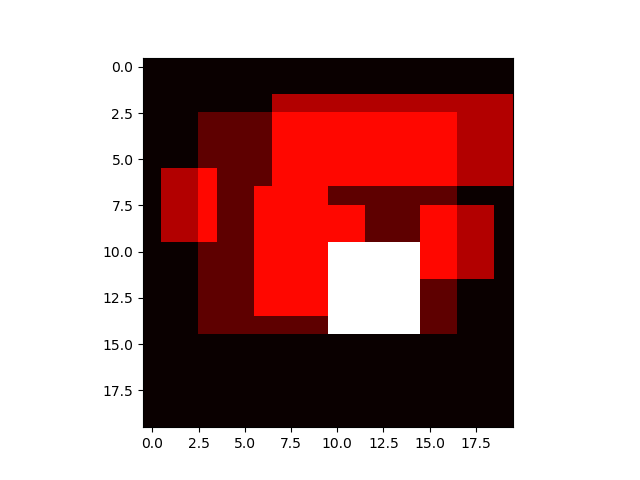

In [8]:
conflict_tower_trimmed = conflict_tower.copy()
conflict_tower_trimmed.trim()

plt.subplots()
im = solver.plot_coverage_overlay(conflict_tower_trimmed, conflict_tower)

The algorithm used for trim is based on the last algorithm on the following webpage:

[The Maximal Rectangle Problem](http://www.drdobbs.com/database/the-maximal-rectangle-problem/184410529)

Code is adapted for a different orientation so that numpy's native vector operations can be utilized. There are also two bugs in the original pseudo code:

1. When re-pushing a active opening, its original height should be used, instead of the current_height.
2. When closing to an opening that happened to have the same height of the current_height, re-pushing is not needed.

This is an O(MN) algorithm. Actual code can be found in `tower.py`. The following code block is a modified version for animation. A short description can be found here:

- First of all, the sub-area of the current coverage of the untrimmed region is retrieved from the solver instance
- For each row, a cache recording numbers of continuous empty space up for each column is updated (represent the light cyan area)
- Initialize the `current_height` to 0 and create an empty stack. Scan from left to right.
    - Whenever the cache value is higher than the `current_height`, push an opening to the stack, which consist of the current column id and the height before the opening.
    - Whenever the cache value is lower than the `current_height`, pop openings from the stack until an opening with lower or equal height to the `current_height` is found. And:
        - For each popped openings, compute the area corresponding to the rectangle bounded by the opening and the closing. If a better solution is found, record it.

Below is an step through animation. Clip on the buttons to control it.

Color legends:

- Black - Blocked
- Dark Cyan - Empty space
- Light Cyan - Current continous space to the up of the current row
- Yellow - Opening ticks
- Purple - Largest rectangle found so far
- White - A new rectangle being examined to see if is larger than the purple one

<IPython.core.display.Javascript object>


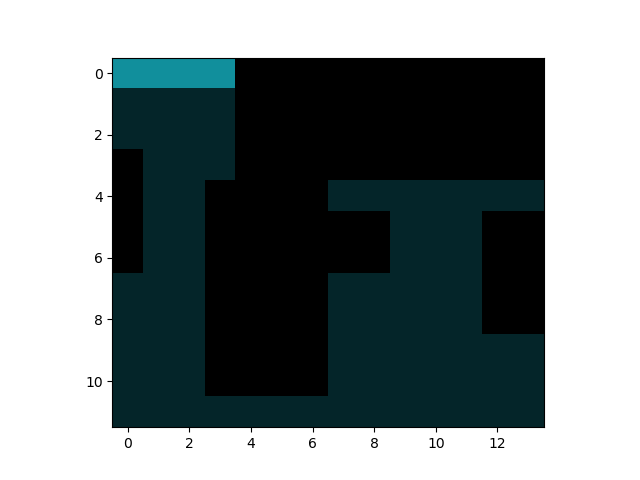

Button(description=u'Reset Animation', style=ButtonStyle())

Button(description=u'Next Step', style=ButtonStyle())

In [9]:
def reset_trim_animation(button=None):
    global _trim_animation
    _trim_animation = conflict_tower.trim_animation()
    _trim_step_button.disabled = False
    step_trim_animation(_trim_step_button)

def step_trim_animation(button=None):
    try:
        _trim_animation.next()
    except StopIteration:
        button.disabled = True

plt.subplots()
        
_trim_reset_button = widgets.Button(description="Reset Animation")
_trim_step_button = widgets.Button(description="Next Step")
_trim_reset_button.on_click(reset_trim_animation)
_trim_step_button.on_click(step_trim_animation)
display(_trim_reset_button)
display(_trim_step_button)

reset_trim_animation(_trim_reset_button)

Now let's clear(reset) the solver and generate random towers.

In [10]:
solver.clear()

`Solver` class provides multiple functions to generate a random tower:

- `generate_random_tower` Generate a random tower whose size and coordinates are uniformly distributed.
- `generate_random_valid_tower_untrimmed` Generate a random tower, and it is guaranteed that its space not fully covered yet. (Otherwise, it can not be trimmed) This function calls `generate_random_tower` until it returns a valid tower. Before that, this function also checks if the current problem is already solved, i.e. the entire problem space has been covered.
- `generate_random_valid_tower_trimmed` Generate a valid tower (defined above), and trim it before returning.

The following code demostrates `generate_random_valid_tower_untrimmed`. You can click on the button to generate a new tower.

<IPython.core.display.Javascript object>


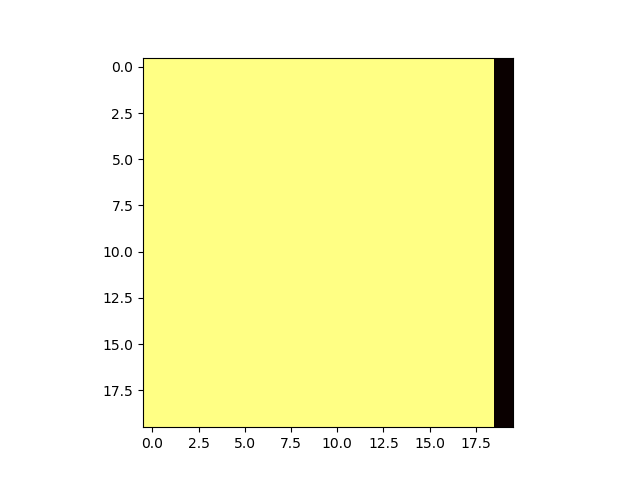

Button(description=u'Generate Tower', style=ButtonStyle())

In [11]:
plt.subplots()
button0 = widgets.Button(description="Generate Tower")

def generate_random_tower(button0):
    global first_tower
    first_tower = solver.generate_random_valid_tower_untrimmed()
    try:
        solver.plot_coverage_overlay(first_tower, im=button0.im)
    except AttributeError:
        button0.im = solver.plot_coverage_overlay(first_tower)

button0.on_click(generate_random_tower)
display(button0)
# Call the function once to generate a tower
generate_random_tower(button0)

Now, let's combine everything above and step through a full simulation. Below the two buttons, there is also a textarea showing the current towers. **You can extend that view to see the tower list.**

<IPython.core.display.Javascript object>


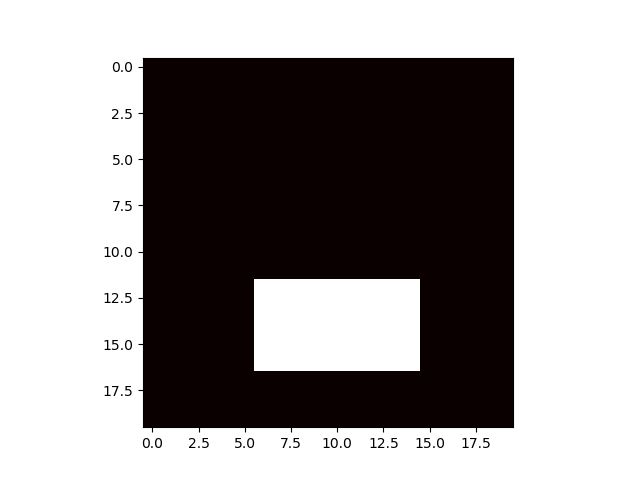

Button(description=u'Reset Simulation', style=ButtonStyle())

Button(description=u'Next Step', style=ButtonStyle())

Textarea(value=u'')

In [12]:
def reset_simulation(button=None):
    solver.clear()
    _simulation_step_button.disabled = False
    step_simulation(_simulation_step_button)

def step_simulation(button=None):
    try:
        tower_untrimmed = solver.generate_random_valid_tower_untrimmed()
        tower_trimmed = tower_untrimmed.copy()
        tower_trimmed.trim()
        solver.plot_coverage_overlay(tower_trimmed, tower_untrimmed)
        solver.add_tower(tower_trimmed)
    except RuntimeError:
        button.disabled = True
    finally:
        _simulation_dump_text.value = solver.dump_towers()

plt.subplots()
        
_simulation_reset_button = widgets.Button(description="Reset Simulation")
_simulation_step_button = widgets.Button(description="Next Step")
_simulation_reset_button.on_click(reset_simulation)
_simulation_step_button.on_click(step_simulation)
_simulation_dump_text = widgets.Textarea()
display(_simulation_reset_button)
display(_simulation_step_button)
display(_simulation_dump_text)

reset_simulation(_simulation_reset_button)